# Module 4: Feature Engineering

Our overall strategy for feature engineering will include the following steps:
1. Apply domain knowledge to drop features that are not interpretable
2. Drop features with too many missing values (attribute sampling)
3. Drop examples with too many missing values (record sampling)
4. Transform numerical features
5. Encode categorical features

## Configuration

In [1]:
# basic configuration, put these lines at the top of each notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# plotting configuration (basically just change plot size)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# show all columns of our data frames
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.precision", 2)
pd.options.display.max_rows = 100

## Data loading

In [4]:
DATA_PATH = 'tmp/'
raw = pd.read_csv(f'{DATA_PATH}data_raw.csv')
raw.shape

(590540, 434)

In [5]:
raw.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

## Data cleaning & sampling

### Applying domain knowledge to reduce features

Most of the features in our dataset were anonymized and are thus hard to interpret. Luckily, Vesta provides some abstract description of the feature groups in a [Kaggle forum post](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-607486). You can see the most important information below.

<img src="img/data_description.png" alt="Data description on Kaggle forum" style="width: 800px" />

Accordingly, we will drop the `V`, `C`, `D` and `id` features because there is no way for us to interpret them during the model evaluation phase.

In [6]:
raw = raw.drop(raw.columns.to_series()["V1":"V339"], axis=1)
raw.shape

(590540, 95)

In [7]:
raw = raw.drop(raw.columns.to_series()["id_01":"id_38"], axis=1)
raw.shape

(590540, 57)

In [8]:
raw = raw.drop(raw.columns.to_series()["C1":"C14"], axis=1)
raw.shape

(590540, 43)

In [9]:
raw = raw.drop(raw.columns.to_series()["D1":"D15"], axis=1)
raw.shape

(590540, 28)

In [10]:
raw = raw.drop(raw.columns.to_series()["M1":"M9"], axis=1)
raw.shape

(590540, 19)

This preliminary step leaves us with 19 features (including the target variable) for now.

### Attribute sampling

Now, we can reuse some code from the previous step to show us which columns have the most missing values. We will then decide how many of these we have to drop.

In [11]:
levels = [0.2, 0.5, 0.8]
missing_val_cols = raw.isnull().sum().sort_values(ascending=False) / len(raw)

for l in levels:
    perc = len(missing_val_cols.loc[missing_val_cols > l]) / len(missing_val_cols)
    print('Percentage of features with more than {:.0f}% missing values: {:.1f}%'.format(l * 100, perc * 100))

Percentage of features with more than 20% missing values: 26.3%
Percentage of features with more than 50% missing values: 26.3%
Percentage of features with more than 80% missing values: 5.3%


In [12]:
missing_val_cols * 100

dist2             93.63
DeviceInfo        79.91
R_emaildomain     76.75
DeviceType        76.16
dist1             59.65
P_emaildomain     15.99
addr2             11.13
addr1             11.13
card2              1.51
card5              0.72
card4              0.27
card6              0.27
card3              0.27
card1              0.00
ProductCD          0.00
TransactionAmt     0.00
TransactionDT      0.00
isFraud            0.00
TransactionID      0.00
dtype: float64

We will set our cutoff at 20% of missing values, i.e., columns with more than 20% of missing values will be dropped. However, we will make an exception for the features `dist1`, `DeviceType` and `R_emaildomain`, since they are interpretable and might be important for predicting fraud. We will also drop two columns that are of no value to use, namely the index column and `TransactionID`.

In [13]:
cutoff = 0.2

cols_to_drop = missing_val_cols.loc[missing_val_cols > cutoff].index.to_list()
cols_to_drop.remove("DeviceType")
cols_to_drop.remove("R_emaildomain")
cols_to_drop.remove("dist1")
cols_to_drop.append("TransactionID")
len(cols_to_drop)

3

In [15]:
print(f'Number of columns before attribute sampling: {raw.shape[1]}')
raw = raw.drop(labels=cols_to_drop, axis=1)
print(f'Number of columns after attribute sampling: {raw.shape[1]}')

Number of columns before attribute sampling: 19
Number of columns after attribute sampling: 16


In [16]:
raw.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,mobile


As we can see, we have 34 features left after accounting for missing values and our domain knowledge.

### Record sampling

Now, we can use a similar process to remove examples with too many missing values. Including these in our analysis might skew the results, because we they contain too many imputed values.

In [17]:
levels = [0.1, 0.2, 0.5]
missing_attrs = raw.isnull().sum(axis=1).sort_values(ascending=False) / raw.shape[1]

for l in levels:
    perc = len(missing_attrs.loc[missing_attrs >= l]) / len(missing_attrs)
    print('Percentage of records with more than {:.0f}% missing values: {:.1f}%'.format(l * 100, perc * 100))

Percentage of records with more than 10% missing values: 90.0%
Percentage of records with more than 20% missing values: 8.1%
Percentage of records with more than 50% missing values: 0.2%


Since we have a lot of data at our hands, we can easily remove all examples with more than 20% of missing data.

In [18]:
cutoff = 0.2

print(f'Number of rows before record sampling: {len(raw)}')
rows_to_drop = missing_attrs.loc[missing_attrs > cutoff].index.to_list()
raw = raw.drop(labels=rows_to_drop, axis=0)
print(f'Number of rows after record sampling: {len(raw)}')

Number of rows before record sampling: 590540
Number of rows after record sampling: 542547


This is a good time to save our progress. We have to reset our index (remember: we remove rows, thus creating holes in the existing index) in order to store the data frame in the efficient _Feather_ format.

In [19]:
raw = raw.reset_index(drop=True)

In [20]:
raw.to_feather(f'{DATA_PATH}feats_raw.feather')

### Dealing with missing values

We still have missing values left in our dataset. In the following, we will discover different ways of dealing with them. Firstly, let's calculate the percentage of missing values in our dataset.

#### Preparation

In [21]:
missing_vals_sum = raw.isnull().sum().sum() 
print(f'Percentage of missing values: {missing_vals_sum / (raw.shape[0] * raw.shape[1]) * 100:.2f}%')

Percentage of missing values: 14.94%


In [22]:
raw.head(n=100)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,NaN
1,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,NaN
2,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,NaN
3,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,mobile
4,0,86510,49.00,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,gmail.com,NaN,NaN
5,0,86522,159.00,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,yahoo.com,NaN,NaN
6,0,86529,422.50,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,mail.com,NaN,NaN
7,0,86535,15.00,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,anonymous.com,NaN,mobile
8,0,86536,117.00,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,yahoo.com,NaN,NaN
9,0,86549,75.89,C,16496,352.0,117.0,mastercard,134.0,credit,NaN,NaN,NaN,gmail.com,gmail.com,desktop


We will deal with missing values for categorical and numerical variables separately. Let's write a helper function that splits these variable types for us (this function is borrowed from the great [fastai library](https://docs.fast.ai/tabular.html).

In [23]:
def cont_cat_split(df, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var: continue
        if df[label].dtype == int or df[label].dtype == float: cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [24]:
num_vars, cat_vars = cont_cat_split(raw, dep_var='isFraud')
print(f'Number of numerical variables: {len(num_vars)}')
print(f'Number of categorical variables: {len(cat_vars)}')

Number of numerical variables: 3
Number of categorical variables: 12


In [25]:
num_vars

['TransactionDT', 'TransactionAmt', 'dist1']

In [26]:
cat_vars

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType']

We will use the `SimpleImputer` from the `scikit-learn` package to impute values for our numeric variables. Here, we will apply the `median` strategy, because both `TransactionAmt` and `dist1` are probably skewed.

#### Replace missing values for numerical features

In [27]:
from sklearn.impute import SimpleImputer
import numpy as np

In [28]:
num_imputer = SimpleImputer(missing_values=np.NaN, strategy="median")

In [29]:
for var in num_vars:
    raw[var] = num_imputer.fit_transform(X=raw[[var]])
raw.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86401.0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,NaN,NaN
1,0,86469.0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,NaN
2,0,86499.0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,NaN,NaN
3,0,86506.0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,8.0,gmail.com,NaN,mobile
4,0,86510.0,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,gmail.com,NaN,NaN


#### Replace missing values for categorical features

Some of our categorical variables have a lot of unique values which slows imputation down a lot. Therefore, we should gather less popular categories which will also our model to make sense of the data.

In [30]:
raw.card1 = raw.card1.astype('int64').astype('category')
raw.card2 = raw.card2.astype('int64').astype('category')
raw.card3 = raw.card3.astype('int64').astype('category')
raw.card5 = raw.card5.astype('int64').astype('category')
raw.addr1 = raw.addr1.astype('int64').astype('category')
raw.addr2 = raw.addr2.astype('int64').astype('category')

In [31]:
def coverage_of_top_n_cats(col, n):
    counts = col.value_counts()
    total_count = counts.sum()
    top_n_count = counts[:n].sum()
    print(f'Coverage of top {n} categories for column {col.name}: {top_n_count/total_count*100:.2f}%')

In [32]:
for var in cat_vars:
    unique_vals = len(pd.unique(raw[var]))
    print(f'Unique values in {var}: {unique_vals}')
    coverage_of_top_n_cats(raw[var], 10)
    coverage_of_top_n_cats(raw[var], 20)
    print("\n")

Unique values in ProductCD: 5
Coverage of top 10 categories for column ProductCD: 100.00%
Coverage of top 20 categories for column ProductCD: 100.00%


Unique values in card1: 13222
Coverage of top 10 categories for column card1: 15.27%
Coverage of top 20 categories for column card1: 22.52%


Unique values in card2: 501
Coverage of top 10 categories for column card2: 47.51%
Coverage of top 20 categories for column card2: 61.26%


Unique values in card3: 109
Coverage of top 10 categories for column card3: 99.35%
Coverage of top 20 categories for column card3: 99.69%


Unique values in card4: 5
Coverage of top 10 categories for column card4: 100.00%
Coverage of top 20 categories for column card4: 100.00%


Unique values in card5: 118
Coverage of top 10 categories for column card5: 95.05%
Coverage of top 20 categories for column card5: 98.68%


Unique values in card6: 4
Coverage of top 10 categories for column card6: 100.00%
Coverage of top 20 categories for column card6: 100.00%


Unique

The top 10 categories describe pretty much most of all our categorical features. We can therefore condense the long tail into one category.

In [33]:
def restructure_numerical_categories(col, n=10):
    top_ten_cats = list(col.value_counts().index[:n])
    mask = [False if row in top_ten_cats else True for row in col]
    temp = col.mask(mask, other=0)
    d = {0: (n+1)}
    for i, cat in zip(list(range(1, (n+1))), top_ten_cats):
        d[cat] = i
    return temp.astype('category').cat.rename_categories(d)

def restructure_string_categories(col, n=10):
    top_ten_cats = list(col.value_counts().index[:n])
    mask = [False if row in top_ten_cats else True for row in col]
    temp = col.mask(mask, other="other")
    return temp.astype('category')

In [34]:
raw.card1 = restructure_numerical_categories(raw.card1)
raw.card2 = restructure_numerical_categories(raw.card2)
raw.card3 = restructure_numerical_categories(raw.card3)
raw.card5 = restructure_numerical_categories(raw.card5)
raw.addr1 = restructure_numerical_categories(raw.addr1)
raw.addr2 = restructure_numerical_categories(raw.addr2)
raw.P_emaildomain = restructure_string_categories(raw.P_emaildomain)
raw.R_emaildomain = restructure_string_categories(raw.R_emaildomain)
raw.head()

/Users/felix/miniconda3/envs/ml_workshop/lib/python3.7/site-packages/pandas/core/generic.py:9316: FutureWarning: Implicitly converting categorical to object-dtype ndarray. One or more of the values in 'other' are not present in this categorical's categories. A future version of pandas will raise a ValueError when 'other' contains different categories.

To preserve the current behavior, add the new categories to the categorical before calling 'where', or convert the categorical to a different dtype.
  errors=errors,


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86401.0,29.0,W,11,11,1,mastercard,4,credit,3,1,8.0,gmail.com,other,NaN
1,0,86469.0,59.0,W,11,4,1,visa,3,debit,6,1,287.0,outlook.com,other,NaN
2,0,86499.0,50.0,W,11,11,1,mastercard,5,debit,11,1,8.0,yahoo.com,other,NaN
3,0,86506.0,50.0,H,11,10,1,mastercard,4,credit,11,1,8.0,gmail.com,other,mobile
4,0,86510.0,49.0,W,11,3,1,visa,1,debit,9,1,36.0,gmail.com,other,NaN


Now, all our large categorical features only contain 11 distinct categories, where the category number also reflects the category's frequency.
At this point, we can impute values for missing values in the categorical variables. We will use constants for this (using the most frequent item would manipulate features with lots of missing values).

In [35]:
cat_imputer = SimpleImputer(missing_values=float('nan'), strategy="constant")

In [36]:
for var in cat_vars:
    raw[var] = cat_imputer.fit_transform(X=raw[[var]])
    raw[var] = raw[var].astype('category')
raw.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86401.0,29.0,W,11,11,1,mastercard,4,credit,3,1,8.0,gmail.com,other,missing_value
1,0,86469.0,59.0,W,11,4,1,visa,3,debit,6,1,287.0,outlook.com,other,missing_value
2,0,86499.0,50.0,W,11,11,1,mastercard,5,debit,11,1,8.0,yahoo.com,other,missing_value
3,0,86506.0,50.0,H,11,10,1,mastercard,4,credit,11,1,8.0,gmail.com,other,mobile
4,0,86510.0,49.0,W,11,3,1,visa,1,debit,9,1,36.0,gmail.com,other,missing_value


In [37]:
raw.addr1.cat.categories

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

After confirming that we don't have any missing values left, we can save our progress and go on to transformation of our features.

In [38]:
missing_vals_sum = raw.isnull().sum().sum() 
print(f'Percentage of missing values: {missing_vals_sum / (raw.shape[0] * raw.shape[1]) * 100:.2f}%')

Percentage of missing values: 0.00%


In [39]:
raw.to_feather(f'{DATA_PATH}feats_clean.feather')

## Transformations of numerical variables

In [40]:
data = pd.read_feather(f'{DATA_PATH}feats_clean.feather')
data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType
0,0,86401.0,29.0,W,11,11,1,mastercard,4,credit,3,1,8.0,gmail.com,other,missing_value
1,0,86469.0,59.0,W,11,4,1,visa,3,debit,6,1,287.0,outlook.com,other,missing_value
2,0,86499.0,50.0,W,11,11,1,mastercard,5,debit,11,1,8.0,yahoo.com,other,missing_value
3,0,86506.0,50.0,H,11,10,1,mastercard,4,credit,11,1,8.0,gmail.com,other,mobile
4,0,86510.0,49.0,W,11,3,1,visa,1,debit,9,1,36.0,gmail.com,other,missing_value


### Decomposition

We will start by making more sense of our datetime feature. Our goal is to decompose it into day of the week and hour of the day. With our anonymized, relative datetime it is hard to retrieve more information.

In [41]:
# offset is used to shift the start/end of a day, experimentation shows that offset of 0.58 is optimal 
def make_day_feature(col, offset=0):
    days = col / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(col):
    hours = col / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [42]:
data['day'] = make_day_feature(data['TransactionDT'], offset=0.58).astype('int64').astype('category')
data['hour'] = make_hour_feature(data['TransactionDT']).astype('int64').astype('category')
print(data.day.describe())
print("\n")
print(data.hour.describe())

count     542547
unique         7
top            1
freq       91238
Name: day, dtype: int64
count     542547
unique        24
top           19
freq       38792
Name: hour, dtype: int64


In [43]:
data = data.drop(["TransactionDT"], axis=1)

In [44]:
data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType,day,hour
0,0,29.0,W,11,11,1,mastercard,4,credit,3,1,8.0,gmail.com,other,missing_value,0,0
1,0,59.0,W,11,4,1,visa,3,debit,6,1,287.0,outlook.com,other,missing_value,0,0
2,0,50.0,W,11,11,1,mastercard,5,debit,11,1,8.0,yahoo.com,other,missing_value,0,0
3,0,50.0,H,11,10,1,mastercard,4,credit,11,1,8.0,gmail.com,other,mobile,0,0
4,0,49.0,W,11,3,1,visa,1,debit,9,1,36.0,gmail.com,other,missing_value,0,0


As you can see, the new features are added to the data frame.

### Rescaling

Rescaling numeric variables is useful for models that are susceptible to different feature ranges, e.g., logistic regression. We will bring all our numeric variables to the range (0, 1) using the `MinMaxScaler` from the `scikit-learn` package. Beforehand, we will use a log transformation in order to de-skew the features.

In [48]:
num_vars, cat_vars = cont_cat_split(data, dep_var='isFraud')
num_vars

['TransactionAmt', 'dist1']

In [49]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

In [50]:
scaler = MinMaxScaler()
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False)

for var in num_vars:
    data[var] = log_transformer.fit_transform(data[[var]])
    data[var] = scaler.fit_transform(data[[var]])
data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType,day,hour
0,0,0.31,W,11,11,1,mastercard,4,credit,3,1,0.24,gmail.com,other,missing_value,0,0
1,0,0.38,W,11,4,1,visa,3,debit,6,1,0.61,outlook.com,other,missing_value,0,0
2,0,0.37,W,11,11,1,mastercard,5,debit,11,1,0.24,yahoo.com,other,missing_value,0,0
3,0,0.37,H,11,10,1,mastercard,4,credit,11,1,0.24,gmail.com,other,mobile,0,0
4,0,0.36,W,11,3,1,visa,1,debit,9,1,0.39,gmail.com,other,missing_value,0,0


### Discretization

We already saw an example of discretization in our exploratory data analysis, when we binned numerical data for plotting. Discretization does not make sense for our features, but an example is included nonetheless. We will use pandas' `cut` function for this.

In [51]:
transaction_amounts = raw.TransactionAmt
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000]

pd.cut(transaction_amounts, bins)

0           (10, 50]
1          (50, 100]
2           (10, 50]
3           (10, 50]
4           (10, 50]
             ...    
542542     (50, 100]
542543      (10, 50]
542544      (10, 50]
542545    (100, 500]
542546    (100, 500]
Name: TransactionAmt, Length: 542547, dtype: category
Categories (8, interval[int64]): [(0, 10] < (10, 50] < (50, 100] < (100, 500] < (500, 1000] < (1000, 5000] < (5000, 10000] < (10000, 50000]]

We can see that the data was discretized into eight bins, replacing the original numeric values.

### Interaction features

Since we only have two numeric features left, there is only one possible interaction term to include in our dataset. We will add a `dist*TransactionAmt` feature and examine whether it might be a good predictor for our target variable.

In [52]:
data['dist1*TransactionAmt'] = data.dist1 * data.TransactionAmt
data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType,day,hour,dist1*TransactionAmt
0,0,0.31,W,11,11,1,mastercard,4,credit,3,1,0.24,gmail.com,other,missing_value,0,0,0.07
1,0,0.38,W,11,4,1,visa,3,debit,6,1,0.61,outlook.com,other,missing_value,0,0,0.23
2,0,0.37,W,11,11,1,mastercard,5,debit,11,1,0.24,yahoo.com,other,missing_value,0,0,0.09
3,0,0.37,H,11,10,1,mastercard,4,credit,11,1,0.24,gmail.com,other,mobile,0,0,0.09
4,0,0.36,W,11,3,1,visa,1,debit,9,1,0.39,gmail.com,other,missing_value,0,0,0.14


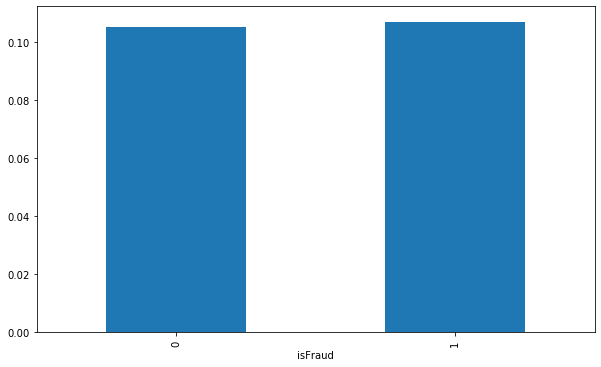

In [53]:
df = data[['isFraud', 'dist1*TransactionAmt']].groupby('isFraud').agg(['mean', 'median'])
df[('dist1*TransactionAmt', 'mean')].plot(kind='bar')
plt.show()

The interaction feature will probably not help much, since the means for both groups are almost identical.

## Encoding of categorical variables

### Encoding schemes

Finally, we should encode our categorical variables in order to derive meaningful features that are also interpretable. Since our categorical features are non-ordinal, we can use one-hot encoding which will create a new feature for every level in each categorical variable. This will results in a "wider" dataset, i.e., a data frame with more columns than before.

In [54]:
one_hot_df = pd.get_dummies(data[cat_vars], prefix=cat_vars)
one_hot_df.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card1_1,card1_2,card1_3,card1_4,card1_5,card1_6,card1_7,card1_8,card1_9,card1_10,card1_11,card2_1,card2_2,card2_3,card2_4,card2_5,card2_6,card2_7,card2_8,card2_9,card2_10,card2_11,card3_1,card3_2,card3_3,card3_4,card3_5,card3_6,card3_7,card3_8,card3_9,card3_10,card3_11,card4_american express,card4_discover,card4_mastercard,card4_missing_value,card4_visa,card5_1,card5_2,card5_3,card5_4,card5_5,card5_6,card5_7,card5_8,card5_9,card5_10,card5_11,card6_charge card,card6_credit,card6_debit,card6_debit or credit,addr1_1,addr1_2,addr1_3,addr1_4,addr1_5,addr1_6,addr1_7,addr1_8,addr1_9,addr1_10,addr1_11,addr2_1,addr2_2,addr2_3,addr2_4,addr2_5,addr2_6,addr2_7,addr2_8,addr2_9,addr2_10,addr2_11,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_comcast.net,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_icloud.com,P_emaildomain_msn.com,P_emaildomain_other,P_emaildomain_outlook.com,P_emaildomain_yahoo.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_comcast.net,R_emaildomain_gmail.com,R_emaildomain_hotmail.com,R_emaildomain_icloud.com,R_emaildomain_msn.com,R_emaildomain_other,R_emaildomain_outlook.com,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,DeviceType_desktop,DeviceType_missing_value,DeviceType_mobile,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
data = pd.concat([data, one_hot_df], axis=1)
data.shape

(542547, 154)

### Large categorical variables

We saw an example of how to deal with large categorical variables, when we limited several features to their top ten categories and an additional `other` category. Other common approaches include feature hashing or bin counting, which we will not further elaborate on here.
An alternative to our approach would be to one-hot encode a feature with many categories and subsequently apply an dimensionality reduction algorithm such as PCA in order to reduce the number of columns. This approach is often used in Kaggle competitions.

## Saving the pre-processed data

In [56]:
data.to_feather(f'{DATA_PATH}feats_final.feather')

In [58]:
!ls -lh tmp/

total 6772336
-rw-r--r--  1 felix  staff   697M Aug 26 15:10 data_raw.csv
-rw-r--r--  1 felix  staff   1.8G Aug 28 09:53 data_raw.feather
-rw-r--r--  1 felix  staff    19M Aug 28 17:00 feats_clean.feather
-rw-r--r--  1 felix  staff    94M Aug 28 17:02 feats_final.feather
-rw-r--r--  1 felix  staff    21M Aug 28 17:00 feats_raw.feather
-rwxr-xr-x@ 1 felix  staff    25M Aug 16 09:26 train_identity.csv
-rwxr-xr-x@ 1 felix  staff   652M Aug 16 09:26 train_transaction.csv


As we can see, our file size is down to less than 100MB from the original 700MB.